# Biomedical Image Analysis

In [4]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Model, load_model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd

In [5]:
def load_normal(norm_path):
    norm_files = np.array(os.listdir(norm_path))
    norm_labels = np.array(['normal']*len(norm_files))
    
    norm_images = []
    for image in tqdm(norm_files):
        image = cv2.imread(norm_path + image)
        image = cv2.resize(image, dsize=(200,200))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        norm_images.append(image)
        
    norm_images = np.array(norm_images)
    print(len(norm_images))
    
    return norm_images, norm_labels
def load_pneumonia(pneu_path):
    pneu_files = np.array(os.listdir(pneu_path))
    pneu_labels = np.array([pneu_file.split('_')[1] for pneu_file in pneu_files])
    
    pneu_images = []
    for image in tqdm(pneu_files):
        image = cv2.imread(pneu_path + image)
        image = cv2.resize(image, dsize=(200,200))
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        pneu_images.append(image)
        
    pneu_images = np.array(pneu_images)
    X_train = np.append(norm_images, pneu_images, axis=0)
    y_train = np.append(norm_labels, pneu_labels)
    
    return pneu_images, pneu_labels

In [6]:
norm_images, norm_labels = load_normal('C:/Users/anask/OneDrive/Desktop/Diplomski/3.sem/ASUB/chest_xray/chest_xray/train/NORMAL/')
pneu_images, pneu_labels = load_pneumonia('C:/Users/anask/OneDrive/Desktop/Diplomski/3.sem/ASUB/chest_xray/chest_xray/train/PNEUMONIA/')

100%|██████████| 1341/1341 [00:28<00:00, 46.69it/s]


1341


100%|██████████| 3875/3875 [00:32<00:00, 119.76it/s]


In [7]:
X_train = np.append(norm_images, pneu_images, axis=0)
y_train = np.append(norm_labels, pneu_labels)

In [8]:
def plot_images(X, y):
    fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(16, 4))

    indices = np.random.choice(len(X), 14)
    counter = 0

    for i in range(2):
        for j in range(7):
            axes[i,j].set_title(y[indices[counter]])
            axes[i,j].imshow(X[indices[counter]], cmap='gray')
            axes[i,j].get_xaxis().set_visible(False)
            axes[i,j].get_yaxis().set_visible(False)
            counter += 1
    plt.show()

In [9]:
norm_images_test, norm_labels_test = load_normal('C:/Users/anask/OneDrive/Desktop/Diplomski/3.sem/ASUB/chest_xray/chest_xray/test/NORMAL/')
pneu_images_test, pneu_labels_test = load_pneumonia('C:/Users/anask/OneDrive/Desktop/Diplomski/3.sem/ASUB/chest_xray/chest_xray/test/PNEUMONIA/')

100%|██████████| 234/234 [00:04<00:00, 50.39it/s]


234


100%|██████████| 390/390 [00:03<00:00, 109.18it/s]


In [10]:
X_test = np.append(norm_images_test, pneu_images_test, axis=0)
y_test = np.append(norm_labels_test, pneu_labels_test)

In [11]:
with open('pneumonia_data.pickle', 'wb') as f:
    pickle.dump((X_train, X_test, y_train, y_test), f)# Use this to load variables
with open('pneumonia_data.pickle', 'rb') as f:
    (X_train, X_test, y_train, y_test) = pickle.load(f)

In [12]:
np.unique(y_train, return_counts=True)

(array(['bacteria', 'normal', 'virus'], dtype='<U8'),
 array([2530, 1341, 1345], dtype=int64))

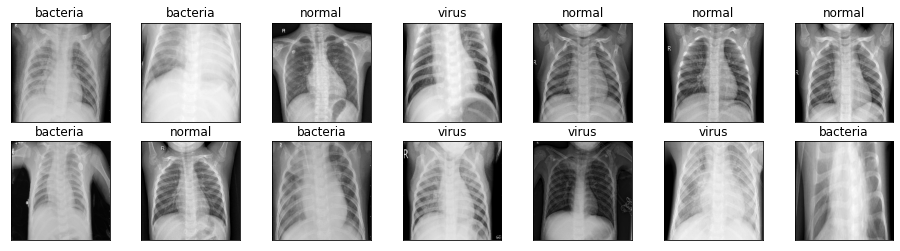

In [13]:
plot_images(X_train, y_train)

In [14]:
np.unique(y_train, return_counts=True)

(array(['bacteria', 'normal', 'virus'], dtype='<U8'),
 array([2530, 1341, 1345], dtype=int64))

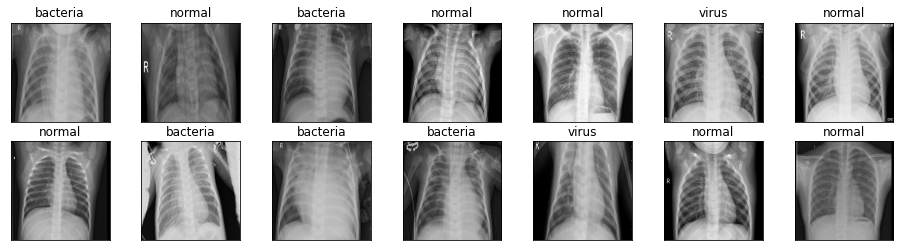

In [15]:
plot_images(X_test, y_test)

In [16]:
y_train = y_train[:, np.newaxis]
y_test = y_test[:, np.newaxis]

In [17]:
one_hot_encoder = OneHotEncoder(sparse=False, handle_unknown = 'error')

In [18]:
y_train_one_hot = one_hot_encoder.fit_transform(y_train)
y_test_one_hot = one_hot_encoder.transform(y_test)

In [19]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [20]:
datagen = ImageDataGenerator(
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

In [21]:
datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train_one_hot, batch_size=32)

In [22]:
input1 = Input(shape=(X_train.shape[1], X_train.shape[2], 1))

cnn = Conv2D(16, (3, 3), activation='sigmoid', strides=(1, 1), 
    padding='same')(input1)
cnn = Conv2D(32, (3, 3), activation='sigmoid', strides=(1, 1), 
    padding='same')(cnn)
cnn = MaxPool2D((2, 2))(cnn)

cnn = Conv2D(16, (2, 2), activation='sigmoid', strides=(1, 1), 
    padding='same')(cnn)
cnn = Conv2D(32, (2, 2), activation='sigmoid', strides=(1, 1), 
    padding='same')(cnn)
cnn = MaxPool2D((2, 2))(cnn)

cnn = Flatten()(cnn)
cnn = Dense(100, activation='relu')(cnn)
cnn = Dense(50, activation='relu')(cnn)
output1 = Dense(3, activation='softmax')(cnn)

model = Model(inputs=input1, outputs=output1)

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 16)      2064      
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 32)      2080      
                                                             

In [24]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [25]:
history2 = model.fit_generator(train_gen, epochs=30, validation_data=(X_test, y_test_one_hot))

C:\Users\anask\AppData\Local\Temp/ipykernel_11724/2115395957.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model.fit_generator(train_gen, epochs=30, validation_data=(X_test, y_test_one_hot))


Epoch 1/30
163/163 [==============================] - 132s 804ms/step - loss: 1.8028 - acc: 0.4057 - val_loss: 1.1575 - val_acc: 0.2372
Epoch 2/30
163/163 [==============================] - 145s 888ms/step - loss: 1.0995 - acc: 0.4446 - val_loss: 1.1019 - val_acc: 0.3878
Epoch 3/30
163/163 [==============================] - 126s 772ms/step - loss: 1.0729 - acc: 0.4755 - val_loss: 1.1144 - val_acc: 0.3878
Epoch 4/30
163/163 [==============================] - 124s 758ms/step - loss: 1.0598 - acc: 0.4816 - val_loss: 1.1083 - val_acc: 0.3878
Epoch 5/30
163/163 [==============================] - 126s 770ms/step - loss: 1.0560 - acc: 0.4850 - val_loss: 1.0877 - val_acc: 0.3878
Epoch 6/30
163/163 [==============================] - 133s 816ms/step - loss: 1.0559 - acc: 0.4850 - val_loss: 1.1029 - val_acc: 0.3878
Epoch 7/30
163/163 [==============================] - 134s 822ms/step - loss: 1.0557 - acc: 0.4829 - val_loss: 1.1291 - val_acc: 0.3878
Epoch 8/30
163/163 [============================

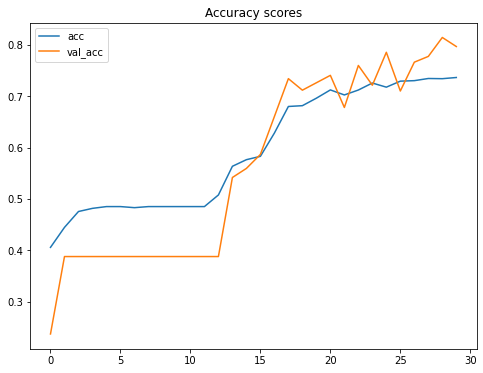

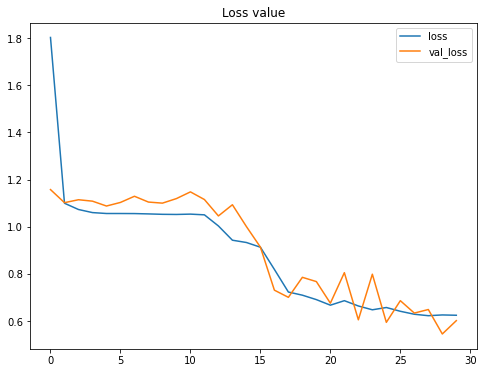

In [26]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.show()
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [27]:
X_train, X_test, y_train_one_hot, y_test_one_hot = train_test_split(
  X_train, y_train_one_hot, test_size=0.2, random_state = 42)

In [28]:
vgg16 = VGG16(weights='imagenet', include_top=False)
hdf5_save = 'VGG16_Model.hdf5'
annealer = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.70, patience=5,
    verbose=1, min_lr=1e-4)
  
checkpoint = ModelCheckpoint(hdf5_save, verbose=1, save_best_only=True)
  
datagen2 = ImageDataGenerator(rotation_range=360,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True)
datagen2.fit(X_train)
train_gen2 = datagen.flow(X_train, y_train_one_hot, batch_size=32)



input = Input(shape=(X_train.shape[1], X_train.shape[2], 1))
x = Conv2D(3, (3, 3), padding='same')(input)

x = vgg16(x)
  
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(200, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output = Dense(3, activation='softmax', name='root')(x)
model2 = Model(input, output)
  
optimizer = Adam(lr=0.003, beta_1=0.9, beta_2=0.999,
                     epsilon=0.1, decay=0.0)
      
model2.compile(loss='categorical_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])
      
model2.summary()
    
history = model2.fit_generator(train_gen2, epochs=30, validation_data=(X_test, y_test_one_hot))


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 200, 200, 3)       30        
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0   

C:\FER\anaconda\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\anask\AppData\Local\Temp/ipykernel_11724/3426482288.py:43: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model2.fit_generator(train_gen2, epochs=30, validation_data=(X_test, y_test_one_hot))


131/131 [==============================] - 1334s 10s/step - loss: 1.2980 - accuracy: 0.5117 - val_loss: 5.9136 - val_accuracy: 0.2883
Epoch 2/30
131/131 [==============================] - 1393s 11s/step - loss: 1.0132 - accuracy: 0.5642 - val_loss: 2.3422 - val_accuracy: 0.4636
Epoch 3/30
131/131 [==============================] - 1296s 10s/step - loss: 0.8370 - accuracy: 0.6237 - val_loss: 2.1336 - val_accuracy: 0.4636
Epoch 4/30
131/131 [==============================] - 1326s 10s/step - loss: 0.7122 - accuracy: 0.6678 - val_loss: 1.6864 - val_accuracy: 0.4473
Epoch 5/30
131/131 [==============================] - 1324s 10s/step - loss: 0.6785 - accuracy: 0.6918 - val_loss: 0.5777 - val_accuracy: 0.7107
Epoch 6/30
131/131 [==============================] - 1276s 10s/step - loss: 0.6349 - accuracy: 0.7047 - val_loss: 0.5579 - val_accuracy: 0.7079
Epoch 7/30
131/131 [==============================] - 1381s 11s/step - loss: 0.5992 - accuracy: 0.7270 - val_loss: 1.8965 - val_accuracy: 0.4

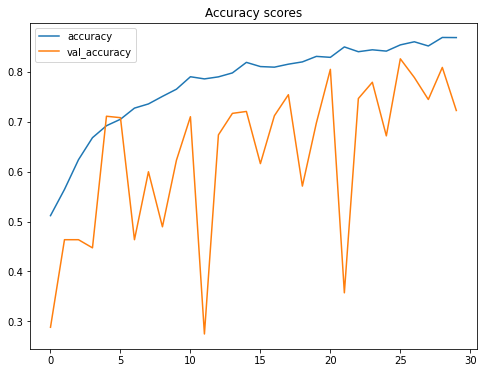

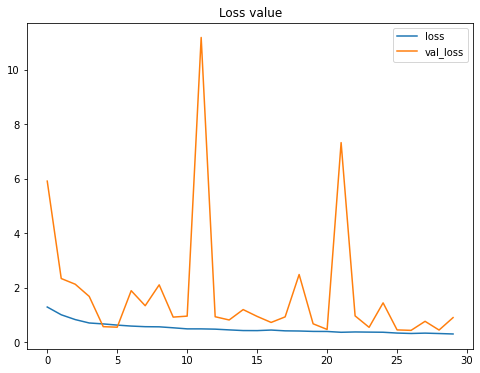

In [34]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [32]:
from sklearn.metrics import confusion_matrix

In [36]:
out = model2.predict(X_test)

33/33 [==============================] - 77s 2s/step


In [41]:
out
outp = np.where(out > .5, 1, 0)
outp

array([[1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0]])

[Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'True')]

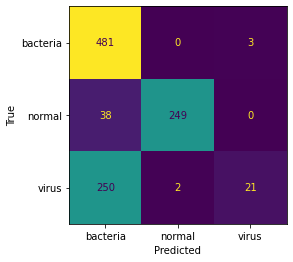

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = ConfusionMatrixDisplay.from_predictions(y_true=y_test_one_hot.argmax(axis=1), y_pred=outp.argmax(axis=1), colorbar=False, display_labels=['bacteria', 'normal', 'virus'])
cm.ax_.set(xlabel='Predicted', ylabel='True')